# God Components project Statistics
## Loading datasets
Import dependencies.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from designite.git_utils import get_commits, compute_locs, git_checkout, get_locs

Load commit data.

In [8]:
commits = get_commits()
commits.head()

,id,author,datetime,message,jira
0,7f65d61b4fe1f4c1d4929bbe1c456c68afd44b6c,THausherr,2020-12-14 06:57:27+01:00,TIKA-3248: revert accidental commit (2nd try),TIKA-3248
1,326b7d7abda238ccc181fc2acaf2271e08fe9c1b,THausherr,2020-12-14 06:34:03+01:00,"Revert ""Merge origin/main into main""",NaN
2,dd85c73094dc87f6f6e208278325be810761f490,THausherr,2020-12-14 05:50:27+01:00,Merge origin/main into main,NaN
3,081070065ec2a989ecfccb9d1186610bbce52f5e,THausherr,2020-12-14 05:46:44+01:00,TIKA-3248: avoid ClassCastException,TIKA-3248
4,3571725a948a4676f1904799209271eeaf18b102,PeterAlfredLee,2020-12-01 10:40:33+08:00,Simplify init code of some Set and List,NaN


Load the aggregated report file, `all_reports.csv`. Contains Designite report data for every single Tika commit.

In [9]:
all_reports = pd.read_csv('designite/output/all_reports.csv')
all_reports.head()

,commit,repo,package,smell,cause,metric
0,49bb4691393c016d8d65e6b11febca9e56feedef,tika-cpu_21,org.apache.tika.example,God Component,MANY_CLASSES,49
1,49bb4691393c016d8d65e6b11febca9e56feedef,tika-cpu_21,org.apache.tika.batch,God Component,MANY_CLASSES,31
2,49bb4691393c016d8d65e6b11febca9e56feedef,tika-cpu_21,org.apache.tika.detect,God Component,MANY_CLASSES,31
3,49bb4691393c016d8d65e6b11febca9e56feedef,tika-cpu_21,org.apache.tika.parser,God Component,MANY_CLASSES,37
4,49bb4691393c016d8d65e6b11febca9e56feedef,tika-cpu_21,org.apache.tika.mime,God Component,MANY_CLASSES,31


Load up Tika's Jira issue tracking issues.

In [10]:
all_issues = pd.read_csv('designite/output/all_issues.csv')
all_issues = all_issues.drop(columns=['id', 'self', 'reporter', 'updated'])
all_issues.head()

,key,resolution,priority,assignee,status,creator,issuetype,resolutiondate,created,components
0,TIKA-3256,Fixed,Minor,tilman,Resolved,tilman,Task,2020-12-27T13:08:45.000+0000,2020-12-27T13:07:15.000+0000,general
1,TIKA-3255,NaN,Major,NaN,Open,peterkronenberg,Bug,NaN,2020-12-22T17:04:55.000+0000,NaN
2,TIKA-3254,NaN,Major,NaN,Open,sathia,Bug,NaN,2020-12-22T13:49:17.000+0000,NaN
3,TIKA-3253,NaN,Minor,NaN,Open,tilman,Improvement,NaN,2020-12-17T08:57:18.000+0000,tika-eval
4,TIKA-3252,NaN,Trivial,NaN,Open,tilman,Bug,NaN,2020-12-17T08:38:45.000+0000,documentation


Load up data on Lines Of Code for every God Component at the state of every commit.

In [11]:
all_locs = get_locs()
all_locs.head()

,additions,deletions,godcomp,id,author,datetime,message,jira,change,LOC
0,6638,0,org.apache.tika.batch,fe4cd58cced0e15f1848afbc2518ab4a66e6867f,Tim Allison,2015-03-23 16:09:10+00:00,initial commit of TIKA-1330,TIKA-1330,6638,6638
1,251,227,org.apache.tika.batch,dbc5eb76b7a21587eba83724e36bff1cb29e72c6,Tim Allison,2015-03-25 17:55:58+00:00,TIKA-1330 clean up logging and some dependenci...,TIKA-1330,24,6662
2,13,14,org.apache.tika.batch,8054dddc156444a0e67a66fcd2dbc9b4bb5db4b7,Tim Allison,2015-03-30 19:43:38+00:00,"TIKA-1330, trivial fixes to avoid NPE with con...",TIKA-1330,-1,6661
3,28,26,org.apache.tika.batch,4ae33b70378e0ee66b7d9c95d6fd7d51b10cc658,Tim Allison,2015-03-31 01:54:40+00:00,TIKA-1330: add integration tests to TikaCLITest,TIKA-1330,2,6663
4,353,334,org.apache.tika.batch,6a013f550bf7e8cfbed4652ec3785e1627d0f7ea,Tim Allison,2015-04-01 18:27:23+00:00,TIKA-1330 clean up logging in tika-batch ant t...,TIKA-1330,19,6682


Combine datasets.

In [12]:
gcdata = commits\
    .merge(all_reports, left_on='id', right_on='commit')
issuedata = gcdata\
    .merge(all_issues, left_on='jira', right_on='key')

## God component lifetime
General statistics on lifetime.

In [13]:
# Compute date data
dt = gcdata.groupby('package')['datetime']
normalize_date = lambda date: pd.to_datetime(date, utc=True)\
                    .dt.tz_convert('Europe/Amsterdam')
dtmin = normalize_date(dt.min())
dtmax = normalize_date(dt.max())
became_gc   = dtmin.dt.strftime('%Y-%m-%d')
last_gc     = dtmax.dt.strftime('%Y-%m-%d')
gc_commits  = dt.count()
gc_days     = (dtmax - dtmin).dt.days

# Compute author data
authors = gcdata.groupby('package')['author'].unique()
n_authors = authors.transform(lambda x: len(x))

# DataFrame
stats = pd.DataFrame([became_gc, last_gc, gc_commits, gc_days, n_authors],
        ['Became GC at', 'Last seen as GC', '# GC commits', '# GC days', '# authors'])\
        .transpose().reset_index()
stats

,package,Became GC at,Last seen as GC,# GC commits,# GC days,# authors
0,org.apache.tika.batch,2015-06-28,2020-12-14,2352,1996,114
1,org.apache.tika.detect,2017-01-19,2020-12-14,1579,1424,82
2,org.apache.tika.example,2015-05-04,2020-12-14,2433,2050,115
3,org.apache.tika.fork,2018-05-31,2020-12-14,738,927,52
4,org.apache.tika.metadata,2016-09-26,2020-12-14,1743,1539,88
5,org.apache.tika.mime,2015-05-02,2020-12-14,2443,2053,115
6,org.apache.tika.parser,2015-02-21,2020-12-14,2429,2123,116
7,org.apache.tika.parser.microsoft,2011-11-25,2020-12-14,3052,3306,121
8,org.apache.tika.parser.microsoft.chm,2020-08-21,2020-12-14,155,114,14
9,org.apache.tika.parser.microsoft.onenote,2019-12-16,2020-12-14,305,363,26


Average over the above stats

In [14]:
stats.agg({
    '# GC commits': 'mean',
    '# GC days': 'mean',
    '# authors': 'mean'
})

# GC commits    1871.800000
# GC days       1820.133333
# authors         81.466667
dtype: float64

Total amount of God Components

<AxesSubplot:xlabel='datetime', ylabel='# god components'>

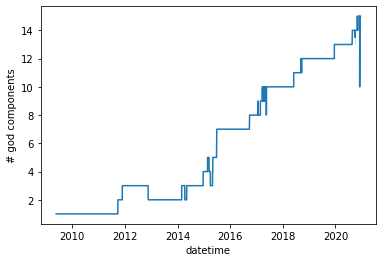

In [15]:
total_gcs = gcdata.groupby(['commit', 'datetime']).count().reset_index()
total_gcs = total_gcs.rename(columns={'metric': '# god components'})
sns.lineplot(data=total_gcs, x='datetime', y='# god components')

Amount of classes per God Component

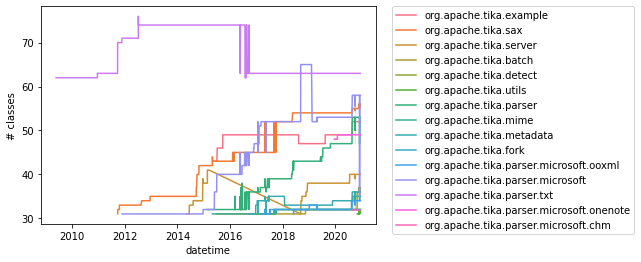

In [16]:
gcdata['# classes'] = gcdata['metric']
sns.lineplot(data=gcdata, x='datetime', y='# classes', hue='package')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## God Components per Line Of Code (LOC)


God Component growth in terms of Lines Of Code

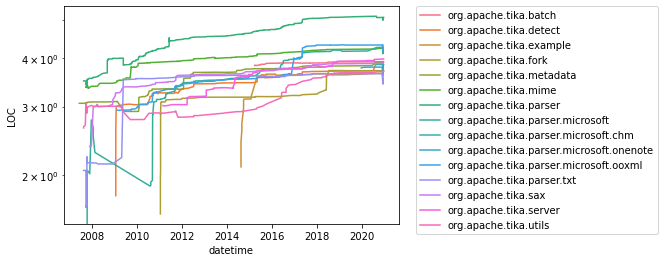

In [6]:
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.lineplot(data=all_locs, x='datetime', y='LOC', hue='godcomp', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [18]:
grouped = all_locs.groupby('godcomp')
# get first 10 commits for every godcomp that 'contributed' most lines of code
grouped = grouped.apply(lambda x: x.assign(total_change = x.additions + x.deletions))
grouped = grouped.reset_index(drop=True).sort_values('total_change', ascending=False)
grouped = grouped.groupby('godcomp').head(1000)
# sort by godcomp then total_change
grouped = grouped.reset_index().sort_values(['godcomp', 'total_change'], ascending=False)
df = grouped.merge(all_issues, left_on='jira', right_on='key')
df.head()

,index,additions,deletions,godcomp,id,author,datetime,message,jira,change,...,key,resolution,priority,assignee,status,creator,issuetype,resolutiondate,created,components
0,4386,532,532,org.apache.tika.utils,d4bb41f7968cb40d39f66b2c0430dde3eef2e618,Jukka Zitting,2007-10-05 08:58:01+00:00,TIKA-44 - Spaces for indentation,TIKA-44,0,...,TIKA-44,Fixed,Trivial,jukkaz,Closed,jukkaz,Bug,2007-10-05T08:58:36.000+0000,2007-10-05T08:50:34.000+0000,general
1,1268,39,40,org.apache.tika.parser,d4bb41f7968cb40d39f66b2c0430dde3eef2e618,Jukka Zitting,2007-10-05 08:58:01+00:00,TIKA-44 - Spaces for indentation,TIKA-44,-1,...,TIKA-44,Fixed,Trivial,jukkaz,Closed,jukkaz,Bug,2007-10-05T08:58:36.000+0000,2007-10-05T08:50:34.000+0000,general
2,4388,286,317,org.apache.tika.utils,6d37de9d208f1f7918df6f81a14a1d3b48a4d37f,Jukka Zitting,2007-10-07 20:01:46+00:00,TIKA-46 - Use Metadata in Parser - With im...,TIKA-46,-31,...,TIKA-46,Fixed,Major,jukkaz,Closed,jukkaz,Improvement,2007-10-07T22:02:38.000+0000,2007-10-07T17:37:43.000+0000,NaN
3,4390,66,95,org.apache.tika.utils,62e58ea2e8ccd2ef1a968349408c990914efa6b6,Jukka Zitting,2007-10-07 22:01:55+00:00,TIKA-46 - Use Metadata in Parser - Moved m...,TIKA-46,-29,...,TIKA-46,Fixed,Major,jukkaz,Closed,jukkaz,Improvement,2007-10-07T22:02:38.000+0000,2007-10-07T17:37:43.000+0000,NaN
4,3894,3,1,org.apache.tika.parser.txt,6d37de9d208f1f7918df6f81a14a1d3b48a4d37f,Jukka Zitting,2007-10-07 20:01:46+00:00,TIKA-46 - Use Metadata in Parser - With im...,TIKA-46,2,...,TIKA-46,Fixed,Major,jukkaz,Closed,jukkaz,Improvement,2007-10-07T22:02:38.000+0000,2007-10-07T17:37:43.000+0000,NaN


In [19]:
issuetypes = df['issuetype'].unique()

def map_issuetype_occurrences(group):
    obj = {}
    for issuetype in issuetypes:
        obj[issuetype] = group[group['issuetype'] == issuetype]['issuetype'].count()
    return pd.Series(obj)
table = df.groupby('godcomp').apply(map_issuetype_occurrences).reset_index()
table

,godcomp,Bug,Improvement,New Feature,Task,Sub-task,Wish,Test
0,org.apache.tika.batch,8,13,2,10,10,0,0
1,org.apache.tika.detect,40,53,33,13,7,3,1
2,org.apache.tika.example,5,17,3,7,6,0,0
3,org.apache.tika.fork,13,15,24,3,2,0,0
4,org.apache.tika.metadata,16,96,16,19,2,0,0
5,org.apache.tika.mime,151,269,59,16,10,6,2
6,org.apache.tika.parser,245,313,129,57,16,12,3
7,org.apache.tika.parser.microsoft,137,176,37,23,2,2,1
8,org.apache.tika.parser.microsoft.chm,1,0,0,3,0,0,0
9,org.apache.tika.parser.microsoft.onenote,0,0,0,3,0,0,0


In [20]:
molten = table.melt(value_vars=issuetypes, id_vars=['godcomp'],\
    var_name='issuetype', value_name='count')
molten

,godcomp,issuetype,count
0,org.apache.tika.batch,Bug,8
1,org.apache.tika.detect,Bug,40
2,org.apache.tika.example,Bug,5
3,org.apache.tika.fork,Bug,13
4,org.apache.tika.metadata,Bug,16
...,...,...,...
100,org.apache.tika.parser.microsoft.ooxml,Test,1
101,org.apache.tika.parser.txt,Test,0
102,org.apache.tika.sax,Test,0
103,org.apache.tika.server,Test,1


Text(0.5, 1.0, 'Amount of commits related to issue types per GC')

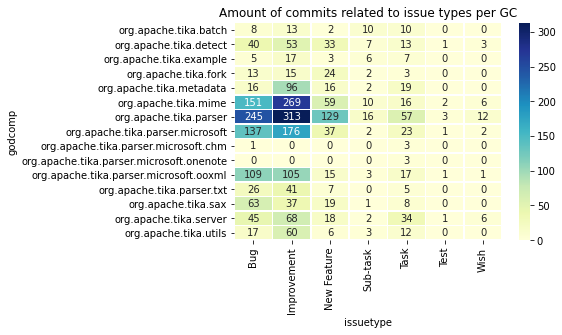

In [21]:
rectangular = pd.pivot_table(molten,\
    values='count',\
    columns=['issuetype'],
    index=['godcomp'])
f, ax = plt.subplots()
plt.yticks(rotation=0)
plt.xticks(rotation=45)
g = sns.heatmap(rectangular,\
    annot=True, fmt='d', linewidths=.5,\
    cmap="YlGnBu", yticklabels=True, ax=ax)
plt.title('Amount of commits related to issue types per GC')